# DTSA 5509 Final Project - Used Car Prices

## Introduction and data

For this project, the problem in question is related to the price of used cars which were sold in the United States. The dataset was obtained from Kaggle and can be found here: https://www.kaggle.com/datasets/harikrishnareddyb/used-car-price-predictions?resource=download

The data includes 7 features and one target variable. The description of the features can be found on the Kaggle page and is as follows:

**Year** - Numerical, year the car was made

**Mileage** - Numerical, the number of kilometers driven by the car

**City** - Location/categorical, city in which the car was sold

**State** - Location/categorical, state in which the car was sold

**Vin** - Textual/categorical, Vehicle Identification Number, a unique identifier for the car

**Make** - Textual/categorical, the manufacturer/brand of the car

**Model** - Textual/categorical, the model(name) of the car

The target variable is the price at which the used car was sold. The task is to perform EDA on the set and train a simple regression model, a multiple linear regression model, and potentially other types of models on the dataset in order to predict price from the 7 other features. Ultimately, the goal is to understand which factors determine the price of a used car and to what extent.

## Data cleaning and EDA

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math

df = pd.read_csv("data/true_car_listings.csv", skipinitialspace=True)

print(df.info())
df.head()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 852122 entries, 0 to 852121
Data columns (total 8 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   Price    852122 non-null  int64 
 1   Year     852122 non-null  int64 
 2   Mileage  852122 non-null  int64 
 3   City     852122 non-null  object
 4   State    852122 non-null  object
 5   Vin      852122 non-null  object
 6   Make     852122 non-null  object
 7   Model    852122 non-null  object
dtypes: int64(3), object(5)
memory usage: 52.0+ MB
None


,Price,Year,Mileage
count,852122.000000,852122.000000,8.521220e+05
mean,21464.100210,2013.289145,5.250779e+04
std,13596.202241,3.414987,4.198896e+04
min,1500.000000,1997.000000,5.000000e+00
25%,13000.000000,2012.000000,2.383600e+04
50%,18500.000000,2014.000000,4.025600e+04
75%,26995.000000,2016.000000,7.218600e+04
max,499500.000000,2018.000000,2.856196e+06


The code above imports the dataset so that cleaning and EDA can begin. There are 852,122 entries for every feature in the dataset.

The dataset does not appear to have any missing values. However, it is worth noting that out of 852,122 entries, there are 852,075 unique values for the VIN. The VIN is supposed to be unique for every car, so this indicates that there are either mistakes with the VIN, duplicate entries, or some cars were simply sold multiple times and data was collected on each instance. After looking at some of the entries with duplicate VINs, it seems that all of these things may be the case for different entries. Since it would be difficult and time-consuming to try to make a decision for each individual row, and there are relatively few duplicates, I have chosen to simply remove all rows with duplicate VINs.

Furthermore, there are 59 unique values for state. Upon closer inspection this turns out to be because sometimes state is listed as two capital letters and sometimes as a capital and a lowercase letter; e.g. Virginia is recorded as both 'VA' and 'Va'. I have corrected this as well.

Another thing that jumps out is the presence of extreme outliers in mileage. These values seem very unlikely and are probably a result of error. I have imputed them using the mean mileage.

In [2]:
#Remove mileage outliers
df.loc[df['Mileage'] >= (52508 + 3*41989), 'Mileage'] = 40256

In [3]:
for c in df.columns:
    print(c, df[c].isnull().sum())

df.nunique()

# Determines which values in vin are duplicates for closer inspection
duplicates=df.duplicated(subset=['Vin'], keep=False)
dup_ind = np.where(duplicates)[0]


for i in range(10):
    val = df['Vin'].iloc[dup_ind[i]]
    print(df.loc[df['Vin'] == val])

#Look at unique values for state
print(df['State'].unique())

Price 0
Year 0
Mileage 0
City 0
State 0
Vin 0
Make 0
Model 0
        Price  Year  Mileage    City State                Vin       Make  \
84302    8599  2012    48618  Morrow    GA  1G1ZB5E09CF258888  Chevrolet   
186430  99999  2012    48618  Morrow    GA  1G1ZB5E09CF258888  Chevrolet   

           Model  
84302   MalibuLS  
186430  MalibuLS  
        Price  Year  Mileage   City State                Vin       Make  \
84753    4289  2016    34449  Blair    NE  1GNSCBKC1GR183490  Chevrolet   
174640  42890  2016    34449  Blair    NE  1GNSCBKC1GR183490  Chevrolet   

           Model  
84753   Tahoe2WD  
174640  Tahoe2WD  
        Price  Year  Mileage     City State                Vin       Make  \
93226   11781  2015    40533  Seattle    WA  1G1PC5SB7F7269381  Chevrolet   
131998  16900  2015    40533  Seattle    WA  1G1PC5SB7F7269381  Chevrolet   

           Model  
93226   Cruze1LT  
131998  Cruze1LT  
        Price  Year  Mileage          City State                Vin  \
107069   1

In [4]:
#check for nonpositive values
print(df[df['Price'] <= 0])
print(df[df['Year'] <= 0])
print(df[df['Mileage'] <= 0])

Empty DataFrame
Columns: [Price, Year, Mileage, City, State, Vin, Make, Model]
Index: []
Empty DataFrame
Columns: [Price, Year, Mileage, City, State, Vin, Make, Model]
Index: []
Empty DataFrame
Columns: [Price, Year, Mileage, City, State, Vin, Make, Model]
Index: []


In [5]:
#clean data and check to make sure there are no more duplicate VINs, and all states are standardized
df.loc[df['State'] == 'ga'] = 'GA'
df.loc[df['State'] == 'Ga'] = 'GA'
df.loc[df['State'] == 'Ca'] = 'CA'
df.loc[df['State'] == 'Md'] = 'MD'
df.loc[df['State'] == 'Va'] = 'VA'
df.loc[df['State'] == 'Oh'] = 'OH'
df.loc[df['State'] == 'Az'] = 'AZ'
df.loc[df['State'] == 'Fl'] = 'FL'
    
df = df.drop_duplicates(subset=['Vin'], keep=False)
        
df.info()
df.nunique()
print(df['State'].unique())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 850507 entries, 0 to 852121
Data columns (total 8 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   Price    850507 non-null  object
 1   Year     850507 non-null  object
 2   Mileage  850507 non-null  object
 3   City     850507 non-null  object
 4   State    850507 non-null  object
 5   Vin      850507 non-null  object
 6   Make     850507 non-null  object
 7   Model    850507 non-null  object
dtypes: object(8)
memory usage: 58.4+ MB
['TX' 'NY' 'CO' 'UT' 'FL' 'CT' 'ID' 'ND' 'CA' 'NJ' 'OH' 'VA' 'IN' 'AZ'
 'OR' 'KS' 'NE' 'MA' 'MD' 'GA' 'MN' 'HI' 'LA' 'NM' 'IL' 'AL' 'PA' 'SC'
 'NC' 'WA' 'WI' 'OK' 'KY' 'MS' 'MO' 'ME' 'AR' 'MI' 'NV' 'TN' 'NH' 'DE'
 'WV' 'VT' 'SD' 'IA' 'RI' 'MT' 'DC' 'AK' 'WY']


In [6]:
df['Price'] = df['Price'].astype('int64')
df['Year'] = df['Year'].astype('int64')
df['Mileage'] = df['Mileage'].astype('int64')
df['City'] = df['City'].astype('category')
df['State'] = df['State'].astype('category')
df['Vin'] = df['Vin'].astype('category')
df['Make'] = df['Make'].astype('category')
df['Model'] = df['Model'].astype('category')

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 850507 entries, 0 to 852121
Data columns (total 8 columns):
 #   Column   Non-Null Count   Dtype   
---  ------   --------------   -----   
 0   Price    850507 non-null  int64   
 1   Year     850507 non-null  int64   
 2   Mileage  850507 non-null  int64   
 3   City     850507 non-null  category
 4   State    850507 non-null  category
 5   Vin      850507 non-null  category
 6   Make     850507 non-null  category
 7   Model    850507 non-null  category
dtypes: category(5), int64(3)
memory usage: 73.0 MB


Price, year, and mileage can remain integers, but I transformed the other feature into categorical variables so they can be used for multiple linear regression.

Below there are visualizations of the features in the dataset. The categorical features are not included because they can take on many levels and a visualization would not be feasible.

Text(0.5, 1.0, 'Histogram of year')

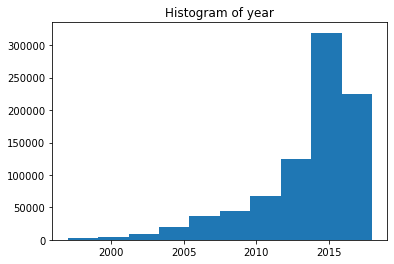

In [7]:
plt.hist(df['Year'])
plt.title("Histogram of year")
#histogram of year

Text(0.5, 1.0, 'Boxplot of price (in $)')

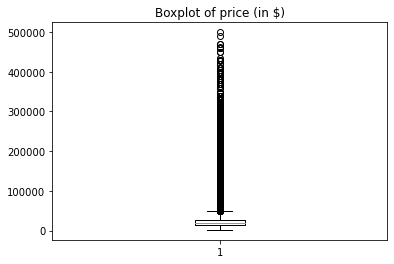

In [8]:
plt.boxplot(df['Price'])
plt.title("Boxplot of price (in $)")
#boxplot of price

The boxplot has many high price values, and is difficult to read. Here it is with the more extreme values removed:

Text(0.5, 1.0, 'Boxplot of price (in $), outliers removed')

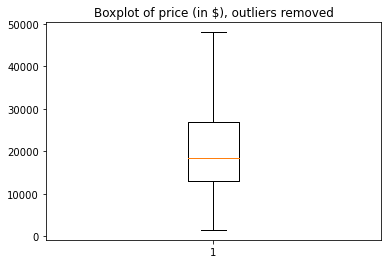

In [9]:
plt.boxplot(df['Price'], showfliers=False)
plt.title("Boxplot of price (in $), outliers removed")
#boxplot of price w/o outliers

Text(0.5, 1.0, 'Boxplot of mileage (in kms driven)')

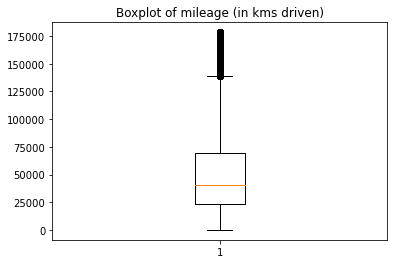

In [10]:
plt.boxplot(df['Mileage'])
plt.title("Boxplot of mileage (in kms driven)")
#boxplot of mileage

Below is a heatmap showing the correlation of the continous numerical features:

<AxesSubplot:>

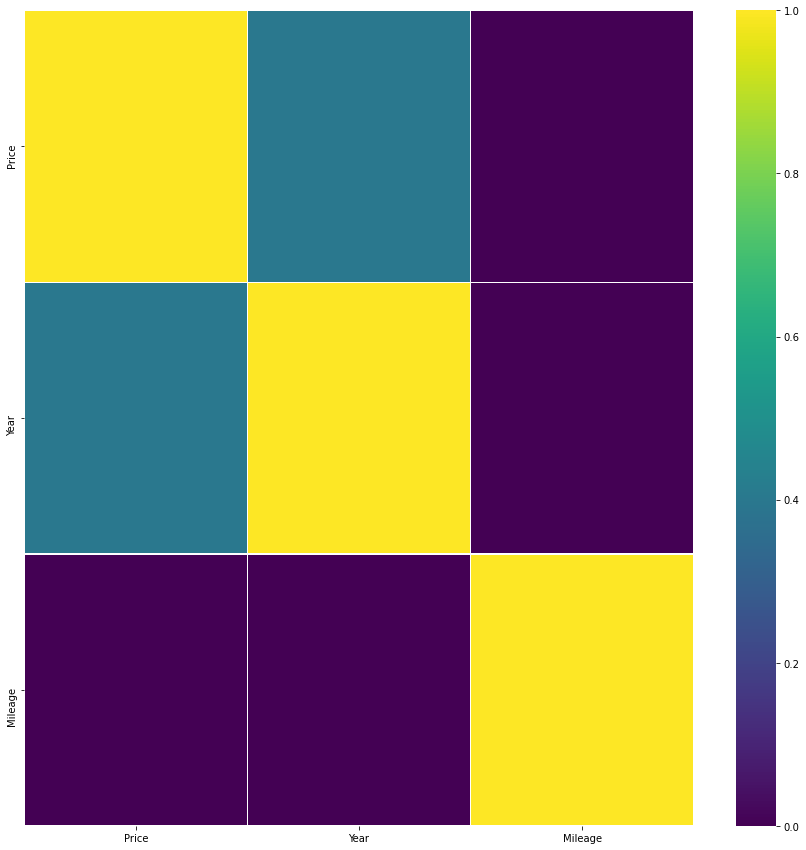

In [11]:
import seaborn as sea
plt.figure(figsize=(15,15))
sea.heatmap(df.corr(), linewidths=0.3, vmin=0, vmax=1, cmap="viridis")

The correlation matrix does not show signs of a high level of correlation between any of these features, although there is some correlation between year and mileage. Based on this and preconceived biases, I expect year will be the most significant feature in the resulting model. I also suspect that VIN will play little to no role since it is essentially a randomly assigned value.

## Model training

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from statsmodels.formula.api import ols

x_train, x_test = train_test_split(df, test_size=0.2, random_state=0)

model = ols('Price ~ Year',x_train)
result = model.fit()
print(result.summary())
print("\nMean squared error is %f \n" %mean_squared_error(x_test['Price'], result.predict(x_test)))

model = ols('Price ~ Mileage',x_train)
result = model.fit()
print(result.summary())
print("\nMean squared error is %f \n" %mean_squared_error(x_test['Price'], result.predict(x_test)))

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.160
Model:                            OLS   Adj. R-squared:                  0.160
Method:                 Least Squares   F-statistic:                 1.298e+05
Date:                Mon, 25 Apr 2022   Prob (F-statistic):               0.00
Time:                        10:53:05   Log-Likelihood:            -7.3826e+06
No. Observations:              680405   AIC:                         1.477e+07
Df Residuals:                  680403   BIC:                         1.477e+07
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -3.19e+06   8912.760   -357.937      0.0

We begin with simple linear regression. Correlation of variables (multicollinearity) can be a concern with linear regression, but this does not seem to be a problem with this dataset, judging by the correlation matrix above. However, it is worth noting that several of the models trained in this section reported a high condition number, which could indicate multicollinearity.

Note: for all p-value comparisons in this section I will be assuming $\alpha=0.05$.

Above are two simple linear regression models to predict `Price`: one with `Year` as the only predictor, and one with `Mileage` as the only predictor. These models were trained on a subset of the data consisting of 80% of the total sample, chosen at random. In both models, the predictor has a very low p-value, indicating that both are significant. However, note the low adjusted $R^2$ values, $0.160$ and $0.177$. The mean squared errors (MSE) were obtained by testing using the remaining 20% of the set and are $154,000,000$ and $151,000,000$. Below is the output of a model predicting `Price` with both `Year` and `Mileage` in multiple linear regression:

In [13]:
model = ols('Price ~ Year + Mileage',x_train)
result = model.fit()
print(result.summary())
print("\nMean squared error is %f \n" %mean_squared_error(x_test['Price'], result.predict(x_test)))

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.196
Model:                            OLS   Adj. R-squared:                  0.196
Method:                 Least Squares   F-statistic:                 8.318e+04
Date:                Mon, 25 Apr 2022   Prob (F-statistic):               0.00
Time:                        10:53:06   Log-Likelihood:            -7.3676e+06
No. Observations:              680405   AIC:                         1.474e+07
Df Residuals:                  680402   BIC:                         1.474e+07
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -1.578e+06   1.27e+04   -124.443      0.0

Again, both predictors have a very low p-value and are significant, the adjusted $R^2$ value has increased and is now $0.196$, and the MSE has fallen to $147,000,000$. Below is the same model, but now with an interaction term for `Year` and `Mileage`.

In [14]:
model = ols('Price ~ Year + Mileage + Year:Mileage',x_train)
result = model.fit()
print(result.summary())
print("\nMean squared error is %f \n" %mean_squared_error(x_test['Price'], result.predict(x_test)))

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.203
Model:                            OLS   Adj. R-squared:                  0.203
Method:                 Least Squares   F-statistic:                 5.775e+04
Date:                Mon, 25 Apr 2022   Prob (F-statistic):               0.00
Time:                        10:53:06   Log-Likelihood:            -7.3648e+06
No. Observations:              680405   AIC:                         1.473e+07
Df Residuals:                  680401   BIC:                         1.473e+07
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept    -2.615e+06   1.88e+04   -138.963   

Again, all predictors appear to be significant, the adjusted $R^2$ has increased further to $0.203$, and the MSE has also come down slightly to $146,000,000$. This suggests that there is a clear interaction between `Year` and `Mileage` and the interaction term should be included, although its effect appears to be small, since the coefficient associated with the term is only $-0.0078$.

In [15]:
model = ols('Price ~ State',x_train)
result = model.fit()
print(result.summary())
print("\nMean squared error is %f \n" %mean_squared_error(x_test['Price'], result.predict(x_test)))

model = ols('Price ~ Make',x_train)
result = model.fit()
print(result.summary())
print("\nMean squared error is %f \n" %mean_squared_error(x_test['Price'], result.predict(x_test)))

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                  0.009
Method:                 Least Squares   F-statistic:                     123.3
Date:                Mon, 25 Apr 2022   Prob (F-statistic):               0.00
Time:                        10:53:09   Log-Likelihood:            -7.4389e+06
No. Observations:              680405   AIC:                         1.488e+07
Df Residuals:                  680354   BIC:                         1.488e+07
Df Model:                          50                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept    2.136e+04    367.716     58.083      

Above are two models predicting `Price` from the categorical variables `State` and `Make`, respectively. The other categorical variables had too many levels for a regression model to be feasible. In the first model using `State`, some of the terms are significant and others are not, with a very low adjusted $R^2$ of $0.009$ and a larger MSE at $182,000,000$. In the second model using `Make`, almost all of the terms are significant, the adjusted $R^2$ is the highest we have seen so far, $0.325$, and the MSE is down to $126,000,000$.

In [16]:
model = ols('Price ~ Year + Mileage + Year:Mileage + Make',x_train)
result = model.fit()
print(result.summary())
print("\nMean squared error is %f \n" %mean_squared_error(x_test['Price'], result.predict(x_test)))

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.531
Model:                            OLS   Adj. R-squared:                  0.531
Method:                 Least Squares   F-statistic:                 1.303e+04
Date:                Mon, 25 Apr 2022   Prob (F-statistic):               0.00
Time:                        10:53:16   Log-Likelihood:            -7.1847e+06
No. Observations:              680405   AIC:                         1.437e+07
Df Residuals:                  680345   BIC:                         1.437e+07
Df Model:                          59                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept             -3.323e+

This last model is another multiple linear regression model, this time combining the continuous numerical variables `Year` and `Mileage` along with their interaction terms with the categorical variable `Make` to predict `Price`. All terms are signficiant according to their respective p-values, the adjusted $R^2$ is much higher at $0.531$, and the MSE has reached its lowest value yet at $87,400,000$. This seems to be the best model as far as linear regression can take us, since adding other predictors is either not feasible or would result in insignificant terms and only a marginal increase to the adjusted $R^2$.

In [30]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV

#convert train and test set to arrays
X = x_train.drop(['Price', 'City', 'State', 'Vin', 'Make', 'Model'], axis=1, inplace=False)
X.head()
y = x_train['Price']
X = np.array(X)
y = np.array(y)

X_test = x_test.drop(['Price', 'City', 'State', 'Vin', 'Make', 'Model'], axis=1, inplace=False)
y_test = x_test['Price']
X_test = np.array(X_test)
y_test = np.array(y_test)


#try different values of hyperparameters max_depth and learning_rate to find best values according to R^2
maxr2 = [-1,-1,-1]

for i in range(1,6):
    for j in range(1,16):
        gbr = GradientBoostingRegressor(max_depth=i, learning_rate=0.04+j*0.01)
        gbr.fit(X,y)

#params = {'max_depth':range(1,3), 'learning_rate':np.logspace(start=0, stop=1, base=2)}
#grid=GridSearchCV(gbr, params) # ToDo: replace it to proper GridSearchCV object and run the grid search with cross validation
#grid.fit(X,y)

        r2 = gbr.score(X_test, y_test)
        if r2 >= maxr2[0]:
            maxr2[0] = r2
            maxr2[1] = i
            maxr2[2] = 0.04+j*0.01

In [29]:
print("Maximum R2 was %f. This was obtained with max_depth=%d and learning_rate=%f." % (maxr2[0], maxr2[1], maxr2[2]))

Maximum R2 was 0.243855. This was obtained with max_depth=4 and learning_rate=0.100000.


Above I used gradient boosting regression to train another type of model to predict `Price` from the other features. I tried a range of values for the hyperparameters max_depth and learning_rate, and chose the combination of parameters that yielded the highest $R^2$ value. This was $0.244$ which occurred when max_depth was $4$ and learning rate was $0.1$.

## Summary and conclusions

As I had expected, `Year` was a significant feature in determining `Price`, however `Make` ultimately proved better able to explain the total variability in `Price`.

In this dataset there were a few issues that made it more difficult than expected to achieve my goals, most significantly the fact that several of the variables could not be used for linear regression. If I were to do this project again, I would choose a dataset with features that were better suited for my purposes.

Other techniques were still viable, such as gradient boosting. I was able to apply my knowledge of hyperparameter tuning from class to determine the best values for the learning rate and maximum depth using gradient boosting. Ultimately, however, this model proved to be inferior, with a much lower $R^2$ value than the multiple linear regression model I settled on earlier.

**References**

HariKrishnaReddyB (2022). *Used car price predictions* [Data set]. Kaggle. https://www.kaggle.com/datasets/harikrishnareddyb/used-car-price-predictions?resource=download